In [215]:
# Import packages
import os, subprocess
import pandas as pd

In [216]:
# Download data
if not os.path.exists('/content/train_data.zip'):
  subprocess.run(['wget', 'https://kelvins.esa.int/media/public/competitions/collision-avoidance-challenge/train_data.zip'])
else:
  print('Training data already downloaded')
if not os.path.exists('/content/test_data.csv'):
  subprocess.run(['wget', 'https://kelvins.esa.int/media/public/competitions/collision-avoidance-challenge/test_data.csv'])
else:
  print('Testing data already downloaded')
# Extract data
if not os.path.exists('/content/train_data.csv'):
  subprocess.run(['unzip', 'train_data.zip'])
else:
  print('Data already extracted')

Training data already downloaded
Testing data already downloaded
Data already extracted


In [252]:
df = pd.read_csv('/content/train_data.csv')
df_test = pd.read_csv('/content/test_data.csv')

In [253]:
SELECTED_INFO_COLUMNS = [
    'event_id', 'risk', 'time_to_tca'
]
SELECTED_FEATURE_COLUMNS = [
    'max_risk_scaling', 'max_risk_estimate', 'c_sigma_tdot', 't_rcs_estimate', 't_span',
    'mahalanobis_distance', 'miss_distance', 'c_span', 'c_sigma_r', 'c_crdot_t', 'c_cd_area_over_mass',
    'c_sigma_n', 'c_sigma_t', "c_ctdot_t", 'c_position_covariance_det', 'c_j2k_sma', 'relative_speed',
    'c_ctdot_rdot', 'relative_velocity_t', 'relative_velocity_r', 'relative_velocity_n', 'c_sigma_ndot',
    'relative_position_n', 'relative_position_r', 'relative_position_t',
]
ALL_SELECTED_COLUMNS = SELECTED_INFO_COLUMNS + SELECTED_FEATURE_COLUMNS
df_training_reduced = df.loc[:, ALL_SELECTED_COLUMNS]
df_test_reduced = df_test.loc[:, ALL_SELECTED_COLUMNS]
df_training_reduced['dataset'] = 'train'
df_test_reduced['dataset'] = 'test'
df_test_reduced['event_id'] = df_training_reduced['event_id'].max() + df_test_reduced['event_id'] + 1
# Combine the training and test data
df_reduced = pd.concat([df_training_reduced, df_test_reduced])
# Make all feature columns numeric
df_reduced[SELECTED_FEATURE_COLUMNS] = df_reduced[SELECTED_FEATURE_COLUMNS].apply(pd.to_numeric)
print("Train events:", len(df_reduced[df_reduced['dataset'] == 'train']['event_id'].unique()))
print("Test events:", len(df_reduced[df_reduced['dataset'] == 'test']['event_id'].unique()))
df_reduced.head(n=5)
#df_reduced[df_reduced['dataset'] == 'test']['event_id'].unique()

Train events: 13154
Test events: 2167


,event_id,risk,time_to_tca,max_risk_scaling,max_risk_estimate,c_sigma_tdot,t_rcs_estimate,t_span,mahalanobis_distance,miss_distance,...,relative_speed,c_ctdot_rdot,relative_velocity_t,relative_velocity_r,relative_velocity_n,c_sigma_ndot,relative_position_n,relative_position_r,relative_position_t,dataset
0,0,-10.204955,1.566798,8.602101,-7.834756,0.165044,0.402,1.0,129.430951,14923.0,...,13792.0,-0.220621,-12637.0,-7.2,-5525.9,0.386462,-13666.8,453.8,5976.6,train
1,0,-10.355758,1.207494,8.956374,-7.848937,0.164383,0.402,1.0,271.540424,14544.0,...,13792.0,-0.203216,-12637.0,-7.0,-5525.9,0.386393,-13319.8,474.3,5821.2,train
2,0,-10.345631,0.952193,8.932195,-7.847406,0.164352,0.402,1.0,347.899292,14475.0,...,13792.0,-0.202320,-12637.0,-7.0,-5525.9,0.386381,-13256.1,474.6,5796.2,train
3,0,-10.337809,0.579669,8.913444,-7.845880,0.164309,0.402,1.0,435.376626,14579.0,...,13792.0,-0.201155,-12637.0,-7.0,-5525.9,0.386400,-13350.7,472.7,5838.9,train
4,0,-10.391260,0.257806,9.036838,-7.852942,0.164172,0.402,1.0,469.178802,14510.0,...,13792.0,-0.197284,-12637.0,-7.0,-5525.9,0.386388,-13288.0,478.7,5811.1,train


In [254]:
# Data cleaning
def extract_means(df, columns):
  '''For each column, extract the mean and std dev. values'''
  means = {}
  stds = {}
  for column in columns:
    means[column] = df[column].mean()
    stds[column] = df[column].std()
  return means, stds
def standardize_column(df, means, stds):
  '''For each column, standardize to 0 mean and 1 std, returning the values needed to do so'''
  for column in means.keys():
    df[column] = (df[column] - means[column]) / stds[column]
  return df

means, stds = extract_means(df_reduced[df_reduced['dataset'] == 'train'], SELECTED_FEATURE_COLUMNS)
df_std = standardize_column(df_reduced, means, stds)

# For each event_id, add a column of time_idx starting at 0 for the largest time_to_tca and going up by 1 for each additional entry
df_std['time_idx'] = (df_std.groupby('event_id', group_keys=True)['time_to_tca'].rank(ascending=False) - 1).astype(int)
df_std = df_std.sort_values(by=['event_id', 'time_idx'])
df_std["event_id"] = df_std["event_id"].astype(str)

# Backfill missing data with the previous entry in each event_id for each columns
# Sanity check that event_id and dataset don't have NAs
assert df_std["event_id"].isna().sum() == 0
assert df_std["dataset"].isna().sum() == 0
df_std = df_std.groupby('event_id', group_keys=False).apply(
  lambda x: x.apply(lambda y: y.fillna(method='ffill', axis=0))
)
# Then fill with the mean
df_std = df_std.apply(
  lambda x: x.fillna(x.mean(skipna=True) if x.dtype == 'float64' else x.mode()[0])
)
df_std.head(n=5)

df_final = df_std.copy()

12656
{'7088': 23, '5319': 23, '11942': 23, '12923': 22, '2549': 22, '10871': 22, '3674': 22, '6145': 22, '2703': 22, '10799': 22, '8718': 22, '3462': 22, '7845': 22, '5152': 22, '8737': 22, '4906': 22, '2697': 22, '7814': 22, '4315': 22, '9919': 22, '11476': 22, '7082': 22, '2805': 22, '10280': 22, '2792': 22, '6227': 22, '9347': 22, '12517': 22, '6221': 22, '2075': 22, '7903': 22, '11932': 22, '220': 22, '4149': 22, '5476': 22, '10309': 22, '2709': 22, '4896': 22, '10566': 22, '2631': 22, '6268': 22, '1531': 22, '681': 22, '5895': 22, '1521': 22, '10728': 22, '7287': 22, '860': 22, '12611': 22, '7633': 22, '12215': 22, '4941': 22, '11513': 22, '848': 22, '1670': 22, '7627': 22, '3825': 22, '12145': 22, '1677': 22, '12710': 22, '5087': 22, '1509': 22, '10364': 22, '7765': 22, '3852': 22, '5126': 22, '13066': 22, '2632': 22, '1902': 22, '4120': 22, '9697': 22, '661': 22, '4580': 22, '9699': 22, '12594': 22, '5944': 22, '5930': 22, '11745': 22, '7949': 22, '1359': 22, '10063': 22, '1014

<Axes: >

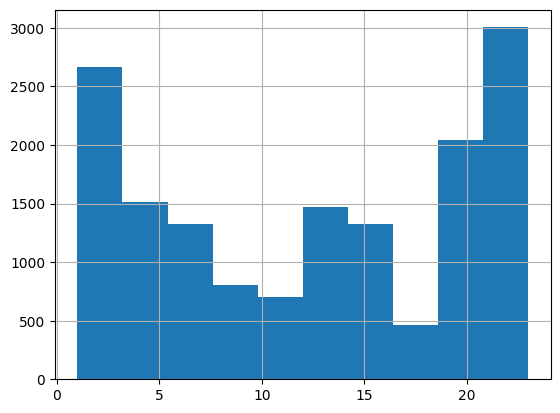

In [255]:
# Find how many entries we have per event_id and the average length
event_counts = df_final['event_id'].value_counts()
event_counts_per_id = event_counts.to_dict()
ids_sufficient_length = event_counts[(event_counts > 3)]
print(len(ids_sufficient_length))
print(event_counts_per_id)
print(event_counts.describe())
event_counts.hist()

In [256]:
# Count the number of events with series length n
counts = event_counts.value_counts()
print(counts.sort_index())
# Extract events with only length 1
debug = df_final[df_final['event_id'].isin(event_counts[event_counts == 1].index)]
debug.head(n=5)

1      300
2     1270
3     1095
4      822
5      694
6      693
7      633
8      388
9      419
10     361
11     341
12     361
13     391
14     717
15    1034
16     291
17     216
18     245
19     494
20    1551
21    2810
22     192
23       3
Name: event_id, dtype: int64


,event_id,risk,time_to_tca,max_risk_scaling,max_risk_estimate,c_sigma_tdot,t_rcs_estimate,t_span,mahalanobis_distance,miss_distance,...,c_ctdot_rdot,relative_velocity_t,relative_velocity_r,relative_velocity_n,c_sigma_ndot,relative_position_n,relative_position_r,relative_position_t,dataset,time_idx
310,13184,-30.000000,2.165526,-0.058748,1.282855,-0.005015,2.003989,1.691264,0.409481,-0.063541,...,-0.001747,-0.026822,0.849535,1.391856,-0.005014,0.745212,0.274760,0.668059,test,0
1104,13256,-30.000000,4.743351,-0.058677,0.303421,-0.005015,-0.265537,0.021740,-0.377220,3.081663,...,-0.001747,1.670020,-0.465376,-0.025087,-0.005014,-0.051387,-0.376908,4.089613,test,0
1346,100,-14.562091,0.033885,-0.059140,-1.492658,-0.120312,-0.163161,0.021740,-0.444111,0.390380,...,-0.533941,-0.535451,-0.167660,-1.217272,-0.120311,-1.205027,-0.606808,0.729154,train,0
1536,13296,-30.000000,4.645815,-0.058677,0.315797,-0.005015,-0.265537,0.021740,-0.377182,3.095890,...,-0.001747,1.670020,-0.468132,0.045538,-0.005014,0.040835,-0.343378,4.103334,test,0
1825,13321,-30.000000,6.368987,-0.058946,0.396938,-0.005015,-0.243359,0.021740,-0.400802,3.123993,...,-0.001747,1.670020,0.469810,0.045463,-0.005014,-0.053099,-0.345396,-4.137694,test,0


In [257]:
# Figure out the smallest time_to_tca for each event id
min_time_to_tca = df_final.groupby('event_id')['time_to_tca'].min()
max_time_to_tca = df_final.groupby('event_id')['time_to_tca'].max()
print(min_time_to_tca)
print(max_time_to_tca)

event_id
0       0.257806
1       3.570013
10      0.297513
100     0.033885
1000    0.205720
          ...   
9995    6.193584
9996    1.036795
9997    0.088839
9998    0.027725
9999    0.184163
Name: time_to_tca, Length: 15321, dtype: float64
event_id
0       1.566798
1       6.530455
10      3.759978
100     0.033885
1000    6.519421
          ...   
9995    6.607617
9996    1.740058
9997    6.757380
9998    3.286219
9999    5.445421
Name: time_to_tca, Length: 15321, dtype: float64


In [258]:
import torch

In [316]:
# Pre-separate and prepare data
all_event_ids = df_final['event_id'].unique()
individual_event_dfs = {
    x:y for x, y in df_final.groupby('event_id')
}
for i in individual_event_dfs:
    individual_event_dfs[i] = individual_event_dfs[i].sort_values(by=['time_idx'])

In [317]:
# Break out all of the features and prepare into lists
selected_features = SELECTED_FEATURE_COLUMNS + ['risk', 'time_idx', 'time_to_tca']
all_features = {}
all_labels = {}
for i in individual_event_dfs:
  event_df = individual_event_dfs[i]
  features = event_df[selected_features].values[:-1]
  label = event_df['risk'].values[-1]
  all_features[i] = torch.tensor(features, dtype=torch.float32)
  all_labels[i] = torch.tensor(label, dtype=torch.float32)

In [318]:
# Separate event ids
test_ids = df_final[df_final['dataset'] == 'test']['event_id'].unique()
non_test_ids = df_final[df_final['dataset'] == 'train']['event_id'].unique()
high_risk_train_ids = []
low_risk_train_ids = []
for i in non_test_ids:
  if all_labels[i] >= -6:
    high_risk_train_ids.append(i)
  else:
    low_risk_train_ids.append(i)
print(f"# test ids: {len(test_ids)}, # train ids: {len(non_test_ids)}, # high-risk train: {len(high_risk_train_ids)}, # low-risk train: {len(low_risk_train_ids)}")

# test ids: 2167, # train ids: 13154, # high-risk train: 365, # low-risk train: 12789


In [319]:
high_risk_train_ids_filtered = [x for x in high_risk_train_ids if event_counts_per_id[x] > 2]
low_risk_train_ids_filtered = [x for x in low_risk_train_ids if event_counts_per_id[x] > 2]
import random
random.seed(42)
train_ids = random.sample(high_risk_train_ids_filtered, int(len(high_risk_train_ids_filtered) * 0.8)) + random.sample(low_risk_train_ids_filtered, int(len(low_risk_train_ids_filtered) * 0.8))
val_ids = list(set(high_risk_train_ids_filtered) - set(train_ids)) + list(set(low_risk_train_ids_filtered) - set(train_ids))
print(f"# train ids: {len(train_ids)}, # val ids: {len(val_ids)}")

# train ids: 9384, # val ids: 2347


In [325]:
class CustomDataloader(object):
  def __init__(self, ids, batch_size, shuffle=True, oversample_ids=None, oversample_factor=4):
    self.ids = ids
    self.oversample_ids = oversample_ids
    self.oversample_factor = oversample_factor
    self.batch_size = batch_size
    self.shuffle = shuffle
    self._make_batches()

  def __len__(self):
    return len(self.batches)

  def _make_batches(self):
    # Prepare batches with samples of same length
    batches = []
    bucket_sizes = list(set(event_counts_per_id.values()))
    for bucket_size in bucket_sizes:
      relevant_ids = [x for x in self.ids if event_counts_per_id[x] == bucket_size]
      if self.oversample_ids is not None:
        additional_ids = [x for x in self.oversample_ids if x in relevant_ids]
        relevant_ids = relevant_ids + additional_ids * self.oversample_factor
      if self.shuffle:
        random.shuffle(relevant_ids)
      for i in range(0, len(relevant_ids), self.batch_size):
        batch = []
        for j in range(i, min(i + self.batch_size, len(relevant_ids))):
          batch.append(relevant_ids[j])
        batches.append(batch)
    if self.shuffle:
      random.shuffle(batches)
    self.batches = batches

  def _gen_bucketed_batches(self):
    for batch in self.batches:
      # Prepare features in shape (batch_size, sequence_length, num_features)
      features = []
      labels = []
      for i in batch:
        features.append(all_features[i])
        labels.append(all_labels[i])
      features = torch.stack(features)
      labels = torch.stack(labels)
      yield features, labels

  def __iter__(self):
    self._make_batches()
    return self._gen_bucketed_batches()

In [326]:
# PyTorch LSTM model
import torch.nn as nn

class LSTMModel(nn.Module):
  def __init__(self, num_features, hidden_size, num_layers):
    super(LSTMModel, self).__init__()
    self.num_features = num_features
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.lstm1 = nn.LSTM(input_size=num_features, hidden_size=hidden_size,
                         num_layers=num_layers, batch_first=True)
    self.linear1 = nn.Linear(hidden_size, 128)
    self.linear2 = nn.Linear(128, 1)

  def forward(self, x):
    out, _ = self.lstm1(x)
    out = nn.functional.relu(self.linear1(out[:, -1, :]))
    out = self.linear2(out)
    return out

# Custom Collision Avoidance Challenge loss function
def ESALoss(x, y): # x is sample, y is ground truth
  # First map x and y to true/false where true is >= 10^-6
  x_bool = x >= -6 # they say 10^-6 but its base 10 log
  y_bool = y >= -6
  # Print number of trues and falses
  #print("Num high risk:",torch.sum(x_bool), torch.sum(y_bool))
  #print("Num low risk:",torch.sum(~x_bool), torch.sum(~y_bool))
  # Compute F2 score
  tp = torch.sum(x_bool & y_bool)
  fp = torch.sum(x_bool & ~y_bool)
  fn = torch.sum(~x_bool & y_bool)
  # Clamp in case of 0
  tp = torch.clamp(tp, min=1)
  fp = torch.clamp(fp, min=1)
  fn = torch.clamp(fn, min=1)
  #print(x_bool.shape, (x_bool & y_bool).shape)
  #print("tp, fp, fn", tp, fp, fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  #print("precision and recall",precision, recall)
  f2 = 5 * precision * recall / (4 * precision + recall)
  # Now compute MSE ONLY on x and y where y_bool is true
  mse = torch.mean((x[y_bool] - y[y_bool]) ** 2)
  mse = torch.clamp(mse, min=1)
  return (1/f2) * mse

def CustomMSE(x,y):
  x = x.squeeze()
  y = y.squeeze()
  # Heavily penalize errors when y >= -6
  y_bool = y >= -6
  mse_high = (x[y_bool] - y[y_bool]) ** 4
  mse_low = (x[~y_bool] - y[~y_bool]) ** 2
  mse = torch.mean(torch.cat([mse_high, mse_low]))
  return mse


In [342]:
# Setup config
batch_size = 128
num_features = len(selected_features)
hidden_size = 64
num_layers = 1
learning_rate = 5e-4
num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [343]:
model = LSTMModel(num_features, hidden_size, num_layers)
model.to(device)
loss_fn = nn.HuberLoss(delta=0.25)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

train_loader = CustomDataloader(train_ids, batch_size=batch_size, shuffle=True, oversample_ids=high_risk_train_ids_filtered, oversample_factor=20)
val_loader = CustomDataloader(val_ids, batch_size=batch_size, shuffle=False)
test_loader = CustomDataloader(test_ids, batch_size=batch_size, shuffle=False)
print("Train load len:", len(train_loader))
print("Val load len:", len(val_loader))

for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0
  for batch_idx, (features, labels) in enumerate(train_loader):
    features, labels = features.to(device), labels.to(device)
    #print(features.shape)
    optimizer.zero_grad()
    outputs = model(features)
    loss = loss_fn(outputs, labels.unsqueeze(1))
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss /= len(train_loader)

  model.eval()
  val_loss = 0.0
  # Store across all batches to compute ESA Loss
  stored_outputs = []
  stored_labels = []
  with torch.no_grad():
    for batch_idx, (features, labels) in enumerate(val_loader):
      features, labels = features.to(device), labels.to(device)
      outputs = model(features)
      loss = loss_fn(outputs, labels.unsqueeze(1))
      stored_outputs.extend(outputs.cpu().numpy())
      stored_labels.extend(labels.cpu().numpy())
      val_loss += loss.item()
    val_loss /= len(val_loader)
  esa_loss = ESALoss(torch.tensor(stored_outputs).squeeze(), torch.tensor(stored_labels).squeeze())

  if epoch % 10 == 0:
    print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss} ESA Loss: {esa_loss}")
  lr_scheduler.step()

Train load len: 122
Val load len: 30
Epoch 0, Train Loss: 3.1455166110249815, Val Loss: 1.3971534053484598 ESA Loss: 40.031654357910156
Epoch 10, Train Loss: 0.2681521510125184, Val Loss: 0.28542625011565786 ESA Loss: 2.7901573181152344
Epoch 20, Train Loss: 0.2313243973614709, Val Loss: 0.27417363786371424 ESA Loss: 2.5290980339050293
Epoch 30, Train Loss: 0.22134859677495772, Val Loss: 0.26726371113575925 ESA Loss: 2.6522841453552246
Epoch 40, Train Loss: 0.19916476388309212, Val Loss: 0.2629837114480324 ESA Loss: 2.516726016998291
Epoch 50, Train Loss: 0.19994648729573142, Val Loss: 0.262024703900291 ESA Loss: 2.927765130996704
Epoch 60, Train Loss: 0.19436641337090463, Val Loss: 0.2618072766034553 ESA Loss: 2.9995172023773193
Epoch 70, Train Loss: 0.1895385928887141, Val Loss: 0.2606219839935269 ESA Loss: 2.937504768371582
Epoch 80, Train Loss: 0.1796402338459004, Val Loss: 0.2599367645821379 ESA Loss: 2.8589704036712646
Epoch 90, Train Loss: 0.17739069463086857, Val Loss: 0.260676

In [336]:
import random
# Understand the model by selecting a few time series and showing the output
val_loader = CustomDataloader(val_ids, batch_size=1, shuffle=False)
model.eval()
collected_labels = []
with torch.no_grad():
  for batch_idx, (features, labels) in enumerate(val_loader):
    features, labels = features.to(device), labels.to(device)
    outputs = model(features)
    # Print results for events of interest (i.e., labels >= -6)
    collected_labels.append(labels.item())
    if torch.sum(labels >= -6) > 0:
      print(f"HIGH Labels: {labels.item()}, Outputs: {outputs.item()}")
    else:
      if random.random() < 0.05:
        print(f"LOW Labels: {labels.item()}, Outputs: {outputs.item()}")

HIGH Labels: -4.948461532592773, Outputs: -6.346537113189697
HIGH Labels: -5.88107442855835, Outputs: -6.399899482727051
HIGH Labels: -5.264880180358887, Outputs: -5.963484764099121
HIGH Labels: -4.631155490875244, Outputs: -9.605117797851562
HIGH Labels: -5.563042640686035, Outputs: -5.0832977294921875
HIGH Labels: -4.822751998901367, Outputs: -5.3624587059021
HIGH Labels: -5.698969841003418, Outputs: -6.579720497131348
LOW Labels: -30.0, Outputs: -30.004283905029297
LOW Labels: -7.64301872253418, Outputs: -7.447175025939941
LOW Labels: -30.0, Outputs: -22.45138931274414
LOW Labels: -7.065905570983887, Outputs: -8.345953941345215
LOW Labels: -14.418050765991211, Outputs: -14.696043014526367
LOW Labels: -8.13471794128418, Outputs: -8.035383224487305
LOW Labels: -6.87160062789917, Outputs: -6.665960311889648
LOW Labels: -30.0, Outputs: -30.010848999023438
LOW Labels: -30.0, Outputs: -30.00505256652832
HIGH Labels: -5.6641411781311035, Outputs: -5.9340314865112305
HIGH Labels: -5.9381709

## NOT USED

In [ ]:
# DATA FRAME PREPARATION
import torch, random


# Sanity check, keep only the event_id, time_idx, and risk
df_reduced = df_final.copy()
# Keep only event_ids in ids_g3_l23
df_reduced = df_reduced[df_reduced['event_id'].isin(ids_g3_l23.index)]
df_reduced = df_reduced[SELECTED_FEATURE_COLUMNS + SELECTED_INFO_COLUMNS + ['time_idx']]
#df_reduced = df_reduced[['event_id', 'time_idx', 'risk']]

# Split the df_reduced into training and validation
# Random split of unique event_ids
import random
random.seed(42)
training_event_ids = random.sample(
    df_reduced['event_id'].unique().tolist(),
    int(len(df_reduced['event_id'].unique()) * 0.8)
)
training_df = df_reduced[df_reduced['event_id'].isin(training_event_ids)]
validation_df = df_reduced[~df_reduced['event_id'].isin(training_event_ids)]
# Reset validation_df event ids to start at 0
validation_df['event_id'] = validation_df['event_id'].astype(int) - validation_df['event_id'].astype(int).min()
validation_df['event_id'] = validation_df['event_id'].astype(str)

training_df.head(n=20)

TOTAL_FEATURE_COLUMNS = SELECTED_FEATURE_COLUMNS + ['risk', 'time_idx']
random.seed(42)
train_set = CustomDataset(training_df, TOTAL_FEATURE_COLUMNS)
random.seed(42)
val_set = CustomDataset(validation_df, TOTAL_FEATURE_COLUMNS)

def padded_collate(batch):
  features, labels = zip(*batch)
  features = torch.nn.utils.rnn.pad_sequence(features, batch_first=True)
  labels = torch.stack(labels)
  return features, labels

In [ ]:
!pip install pytorch-forecasting
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline

<ipython-input-26-db210e746bb5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df['event_id'] = validation_df['event_id'].astype(int) - validation_df['event_id'].astype(int).min()
<ipython-input-26-db210e746bb5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df['event_id'] = validation_df['event_id'].astype(str)


,event_id,time_idx,risk
0,0,0,-10.204955
1,0,1,-10.355758
2,0,2,-10.345631
3,0,3,-10.337809
4,0,4,-10.391260
5,1,0,-7.561299
6,1,1,-9.315693
7,1,2,-7.422508
8,1,3,-9.248105
9,2,0,-10.816161


In [ ]:
dataset = TimeSeriesDataSet(
    training_df,
    time_idx = "time_idx",
    group_ids = ["event_id"],
    target = "risk",
    min_encoder_length = 1,
    max_encoder_length = int(df_reduced["time_idx"].max()),
    static_categoricals=["event_id"],
    time_varying_unknown_reals=["risk"]
)
val_dataset = TimeSeriesDataSet.from_dataset(dataset, validation_df, predict=True, stop_randomization=False)

dataloader = dataset.to_dataloader(train=True, batch_size=64, num_workers=0)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/timeseries.py:1301: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 183 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__event_id': '100'}, {'__group_id__event_id': '10025'}, {'__group_id__event_id': '10151'}, {'__group_id__event_id': '1021'}, {'__group_id__event_id': '10349'}, {'__group_id__event_id': '10382'}, {'__group_id__event_id': '10522'}, {'__group_id__event_id': '10612'}, {'__group_id__event_id': '10997'}, {'__group_id__event_id': '1104'}]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/timeseries.py:1207: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/timeseries.py:13

In [ ]:
# Evaluate the baseline model
from pytorch_forecasting.metrics import RMSE
baseline = Baseline().predict(val_dataloader, return_y=True)
RMSE()(baseline.output, baseline.y)

<ipython-input-33-2d5ed4bf619a>:3: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline = Baseline().predict(val_dataloader, return_y=True)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilit

tensor(6.4232, device='cuda:0')

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continue

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.
INFO: LR finder stopped early after 0 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 0 steps due to diverging loss.
ERROR: Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
ERROR:lightning.pytorch.tuner.lr_finder:Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
INFO: Restoring states from the checkpoint path at /content/.lr_find_b7004470-4a41-4257-ac8a-09a444ee79a5.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_b7004470-4a41-4257-ac8a-09a444ee79a5.ckpt
INFO: Restored all states from the checkpoint at /content/.l

suggested learning rate: None


ValueError: x and y must have same first dimension, but have shapes (1000,) and (0,)

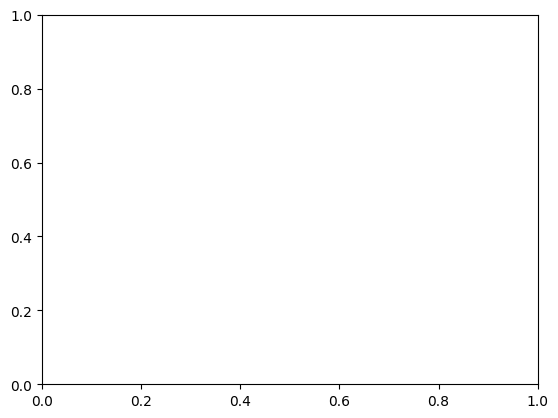

In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(
    gradient_clip_val=0.1
)

tft = TemporalFusionTransformer.from_dataset(
    dataset,
    learning_rate=0.03,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=RMSE(),
)

from lightning.pytorch.tuner import Tuner
res= Tuner(trainer).lr_find(
    tft,
    train_dataloaders=dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10,
    min_lr=1e-6
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
trainer.fit(tft, train_dataloaders=dataloader, val_dataloaders=val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 104 K  | train
3  | prescalers                         | ModuleDict                      | 432    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 406    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 10.7 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.
